In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import cartopy.crs as ccrs

In [3]:
import h5py
import matplotlib.patches as patches

In [4]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

List of parameters:
* PRECT: Total (convective and large-scale) precipitation rate (liq + ice)
* PS: Surface pressure
* PSL: sea level pressure
* QREFHT: Reference height humidity
* T200: temp at 200 mbar pressure surface
* T500: temp at 500 mbar pressure surface
* TMQ: Total (vertically integrated) precipitatable water
* TS: Surface temperature (radiative)
* U850: Zonal wind at 850 mbar pressure surface
* UBOT: Lowest model level zonal wind
* V850: Meridional wind at 850 mbar pressure surface
* VBOT: Lowest model level meridional wind
* Z100: Geopotential Z at 100 mbar pressure surface
* Z200: Geopotential Z at 200 mbar pressure surface
* ZBOT: Lowest model level height

4 measures per day, 365 days a year
resolution of 768 x 1152 equirectangular grid (25-km at equator)

boxes:
* ymin
* xmin
* ymax
* xmax
* class:
    * 0: Tropical Depression
    * 1: Tropical Cyclone
    * 2: Extratropical Cyclone
    * 3: Atmospheric River

In [5]:
year = 2005
datapath = '../data/ExtremeWeather/climo_{}.h5'.format(year)

In [6]:
h5f = h5py.File(datapath)
images = h5f["images"] # (1460,16,768,1152) numpy array
boxes = h5f["boxes"] # (1460,15,5) numpy array

In [7]:
lon_ = np.arange(1152)/1152*360
lat_ = np.arange(768)/768*180-90
lon, lat = np.meshgrid(lon_, lat_)

no box
no box
no box
no box
no box
no box
no box
no box
no box
no box
no box
no box
no box


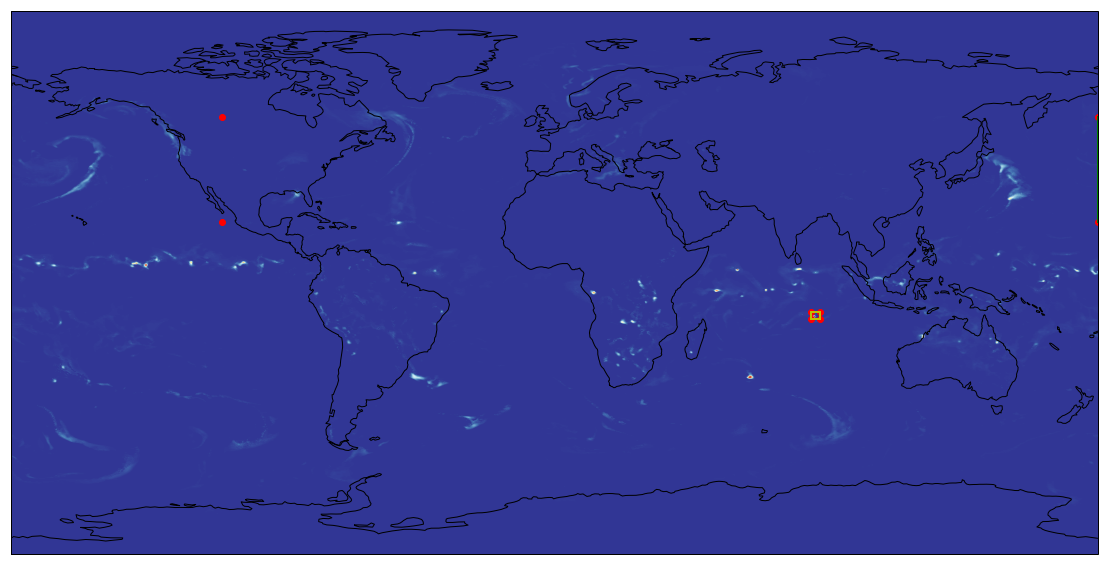

In [80]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(lon, lat, s=1,
            c=images[0,0,:,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

color = ['r', 'y', 'c', 'g']

for i in range(15):
    ymin, xmin, ymax, xmax, clas = boxes[0,i]
    if ymin==-1:
        print("no box")
        continue
    ymin, ymax = lat_[ymin], lat_[ymax]
    xmin, xmax = lon_[xmin], lon_[xmax]
    plt.scatter(np.array([xmin, xmin, xmax, xmax]),np.array([ymin, ymax, ymin, ymax]), c='r')
    rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=2,edgecolor=color[clas],facecolor='none')
    ax.add_patch(rect)

In [8]:
from scipy.interpolate import griddata, RectBivariateSpline, RegularGridInterpolator, LinearNDInterpolator, interp2d

In [9]:
from scipy.interpolate import griddata#, RectBivariateSpline, RegularGridInterpolator
Nside = 64
pix = np.arange(12*Nside**2)
coords_hp = hp.pix2ang(Nside, pix, nest=True, lonlat=True)
coords_hp = np.asarray(coords_hp).T
# lon_rad, lat_rad = np.deg2rad(lon), np.deg2rad(lat)
coords_map = hp.ang2vec(lon, lat, lonlat=True).reshape((-1, 3))
coords_map = np.stack([lon, lat], axis=-1).reshape((-1, 2))
# map_hp = griddata(coords_map, images[0,0].flatten(), coords_hp, 'linear')

In [15]:
t = time.time()
map_hp1 = griddata(coords_map, images[0,0].flatten(), coords_hp, 'linear')
print("time taken:", time.time()-t)

# t = time.time()
# map_hp2 = griddata(coords_map, images[0,0].flatten(), np.asarray(coords_hp).T, 'linear')
# print("time taken:", time.time()-t)

# t = time.time()
# f = interp2d(lon_, lat_, images[0,0])
# map_hp3 = np.diag(f(*coords_hp))  # False result???
# print("time taken:", time.time()-t)

t = time.time()
f = RegularGridInterpolator((lon_, lat_), images[0,0].T)
map_hp3 = f(coords_hp)
print("time taken:", time.time()-t)

time taken: 22.617297649383545
time taken: 1.0223331451416016


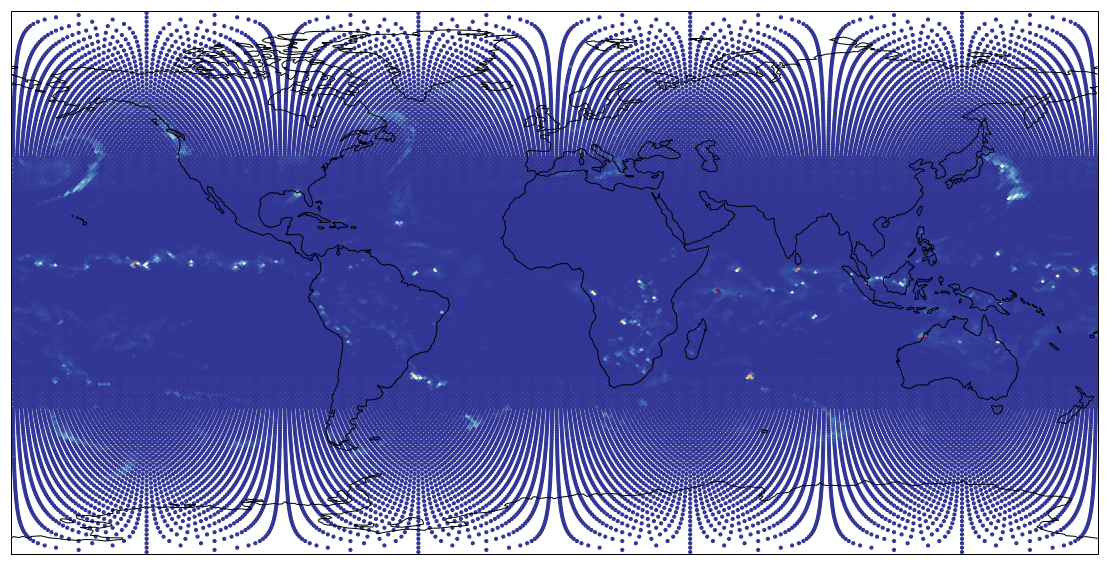

In [17]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=map_hp1, cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

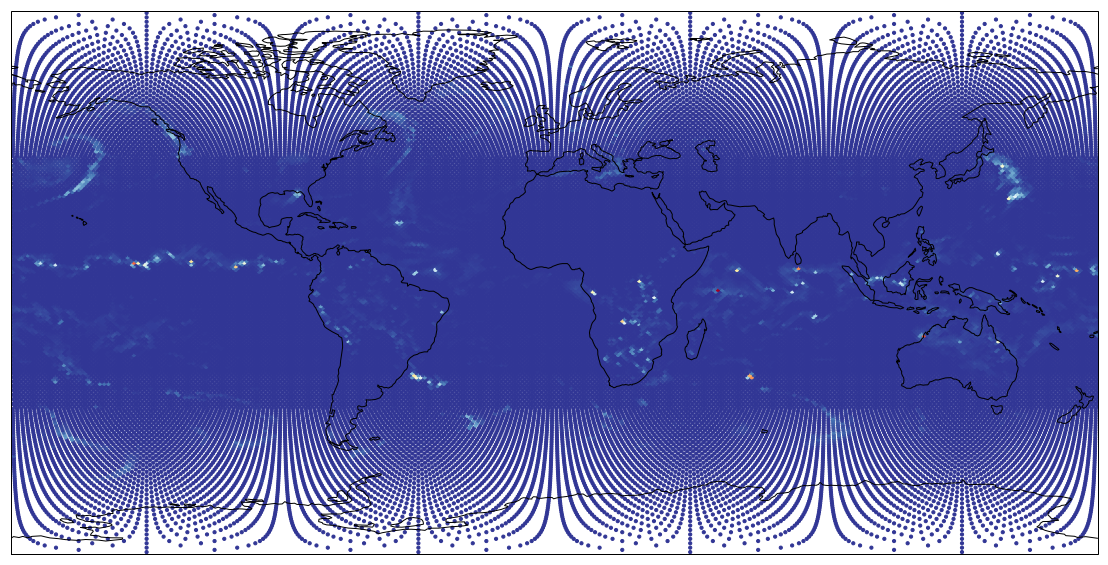

In [27]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=map_hp3, cmap=plt.get_cmap('RdYlBu_r'), alpha=1)
# indic = np.where(~np.isclose(map_hp1, map_hp3, atol=1e-6))
# plt.scatter(coords_hp[indic,0], coords_hp[indic,1], s=10,
#             c='r')

In [ ]:
data_path = '../data/ExtremeWeather/'
measures, channels, lat_x, lon_x = images.shape
nfeat = 5
Nside = [32, 64]
for nside in Nside:
    npix = hp.nside2npix(nside)
    data = np.empty((measures, npix, channels))
    labels = np.zeros((measures, npix))
    pix = np.arange(npix)
    coords_hp = hp.pix2ang(nside, pix, nest=True, lonlat=True)
    coords_hp = np.asarray(coords_hp).T
    for measure in tqdm(range(measures)):
        for channel in tqdm(range(channels)):
#             data[measure,:,channel] = griddata(coords_map, images[measure,channel].flatten(), coords_hp, 'linear')
            f = RegularGridInterpolator((lon_, lat_), images[measure,channel].T)
            data[measure,:,channel] = f(coords_hp)
        for box in range(boxes.shape[1]):
            ymin, xmin, ymax, xmax, clas = boxes[measure,box]
            if ymin==-1:
#                 print("no box")
                continue
            ymin, ymax = lat_[ymin%lat_x], lat_[ymax%lat_x]
            xmin, xmax = lon_[xmin%lon_x], lon_[xmax%lon_x]
            if xmax>xmin and ymax>ymin:
                indexes = np.where(np.logical_and(np.logical_and(coords_hp[:,0]>=xmin, coords_hp[:,0]<=xmax), 
                                        np.logical_and(coords_hp[:,1]>=ymin, coords_hp[:,1]<=ymax)))
            else:
                indexes = np.where(np.logical_and(np.logical_or(coords_hp[:,0]>=xmin, coords_hp[:,0]<=xmax), 
                                        np.logical_and(coords_hp[:,1]>=ymin, coords_hp[:,1]<=ymax)))
            labels[measure, indexes] = clas + 1
#             if xmax<=xmin or ymax<=ymin:
#                 print(xmin, ymin, xmax, ymax)
#                 print(labels[measure, indexes])
#                 fig = plt.figure(figsize=(25, 50))
#                 ax = fig.add_subplot(211)
#                 ax.scatter(coords_hp[:,0], coords_hp[:,1], 
#                            c=labels[measure,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)
#                 ax2 = fig.add_subplot(212, projection=ccrs.PlateCarree())
#                 ax2.set_global()
#                 plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
#                     c=labels[measure,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)
#                 break
#         if (xmax<=xmin or ymax<=ymin) and ymin!=-1:
#             break
#     break
    file = data_path + 'EW_{}nside_{}'.format(nside, year)
    np.savez(file, data=data, labels=labels)
    break

  0%|          | 0/16 [00:00<?, ?it/s]


  6%|▋         | 1/16 [00:01<00:15,  1.01s/it]


 12%|█▎        | 2/16 [00:02<00:15,  1.08s/it]


 19%|█▉        | 3/16 [00:03<00:14,  1.10s/it]


 25%|██▌       | 4/16 [00:04<00:13,  1.09s/it]


 69%|██████▉   | 11/16 [00:15<00:06,  1.39s/it]

In [87]:
file = data_path + 'EW_{}nside_{}'.format(Nside, year)

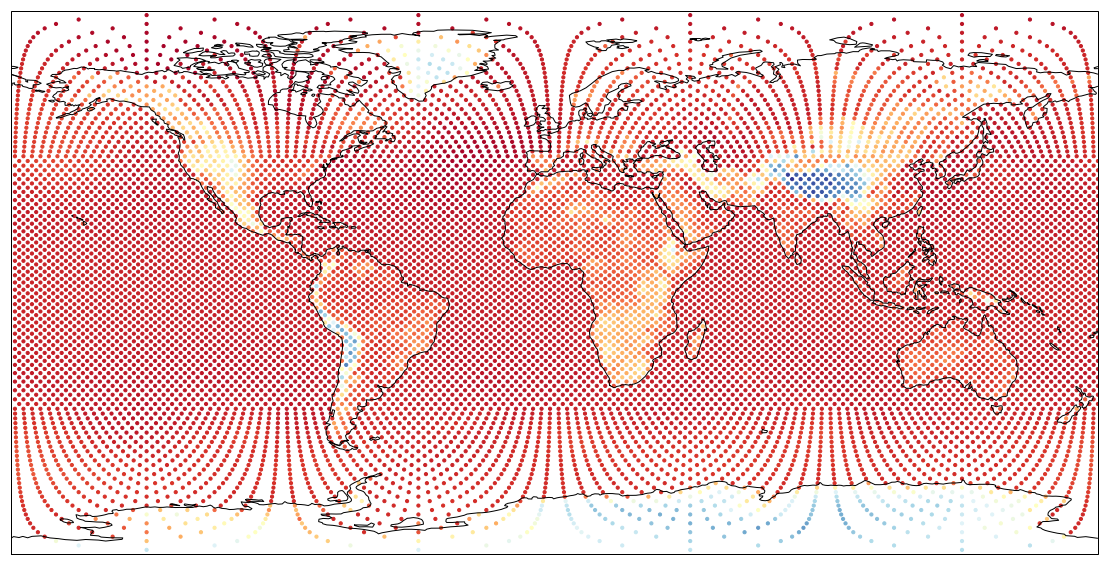

In [40]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=data[0,:,1], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

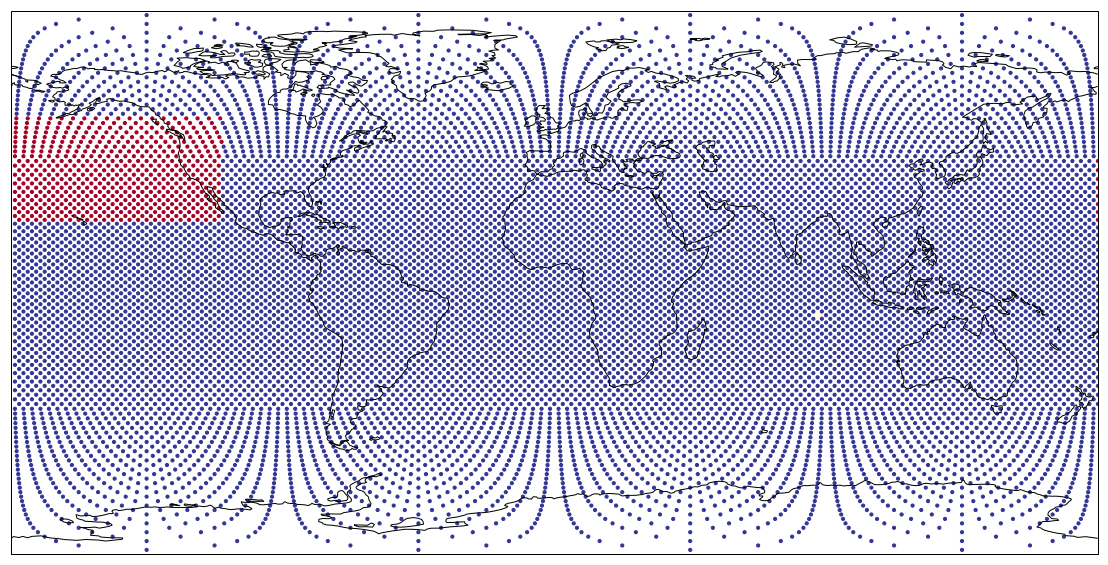

In [37]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=labels[0,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)